In [1]:
import sys
import math
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
from models.radar import radar_factory
import math
from models.sc_net import SCnet
import pickle
from dataset.tmQM_data import tmQM_dataset,tmQM_wrapper
import yaml
from dataset.prepocess import draw_entirety
from dataset.prepocess import draw_ligands
from tqdm import tqdm
import sklearn.metrics as sm

In [3]:
LABEL_NAME = ['EE','DE','\u03BC','MC','H/L Gap','HOMO-E','LUMO-E','\u03B1']

# 标签顺序
rank = [0,5,3,1,2,6,7,4]
label = [LABEL_NAME[i] for i in rank]

def read_data(experiments):
    root_dir = './experiment/'
    means = []
    stds = []
    for exper in experiments:
        path = root_dir + exper + '/result.csv'
        data = pd.read_csv(path).to_numpy()
        means.append(np.mean(data,axis=0))
        stds.append(np.std(data,axis=0))
    means = np.array(means)
    stds = np.array(stds)
    return means,stds

In [4]:
def radar(data,label,index,title):
    N = 8
    data.append([0 for i in range(8)])
    theta = radar_factory(N, frame='polygon')
    spoke_labels = label
    
    fig, axs = plt.subplots(figsize=(9,8), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['blue','blueviolet','green', 'orange','gold','red','slategray','lightseagreen','chocolate',]
    
    ax = axs
    d = data
    ax.set_rgrids([1,2,3,4,5])
    for d, color in zip(data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = index
    legend = ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='medium')

    fig.text(0.5, 0.965, title,
                horizontalalignment='center', color='black', weight='bold',
                size='large')

    plt.savefig('./results/'+title+'.tif',dpi=600)
    plt.show()

In [5]:
def cal_area(data,plot=False,lable=None,title=None):
    areas = [0 for i in range(len(data))]
    for ind,poly in enumerate(data[:-1]):
        for i,r in enumerate(poly):
            if i == 7:
                areas[ind] += 0.5*r*poly[0]*math.sin(math.pi/4)
            else:
                areas[ind] += 0.5*r*poly[i+1]*math.sin(math.pi/4)
    diff = [np.round(areas[i]/areas[0],2) for i in range(0,len(areas)-1)]
    if plot:
        plt.figure(figsize=(6,3))
        plt.plot(lable,diff[:-1],'-',color='dodgerblue')
        plt.plot(lable,diff[:-1],'*',color='dodgerblue')
        plt.savefig('./results/'+title+'.tif',dpi=600)
        plt.show()
    return diff

In [6]:
def table(experiments,title,index,mode='a'):
    times = np.array([0.01,1000,1,100,100,1000,1000,1])
    means,std = read_data(experiments)
    means = np.round(means*times,decimals=2)
    std = np.round(std*times,decimals=2)
    res = []
    for i in range(means.shape[0]):
        res.append([])
        for j in range(means.shape[1]):
            res[-1].append(str(means[i][j])+'\u00B1'+str(std[i][j]))
    df = pd.DataFrame(res,index,LABEL_NAME)
    with pd.ExcelWriter('./results/result.xlsx',mode=mode) as writer:
        df.to_excel(writer,sheet_name=title)

* #### 无金属、简单分离式、分离配位式、完全式对比雷达图

In [7]:
areas = []

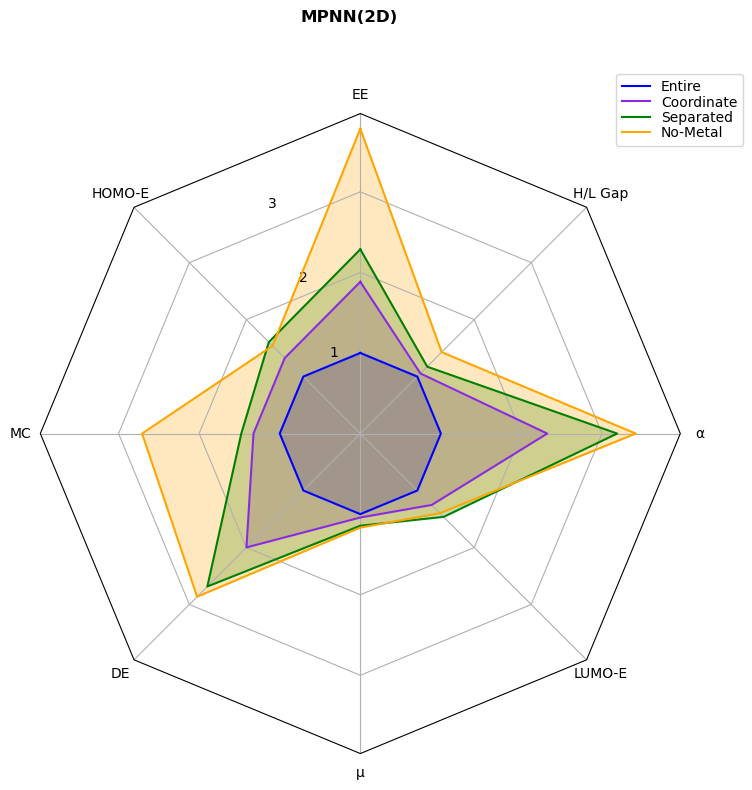

In [8]:
title = 'MPNN(2D)'
experiments = ['SCnet-GCN_en_no_laplace_2d_2d_1','SCnet-GCN_se_att_laplace_2d_2d_1','SCnet-GCN_se_no_laplace_2d_2d_1','SCnet-GCN_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','No-Metal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index,title))

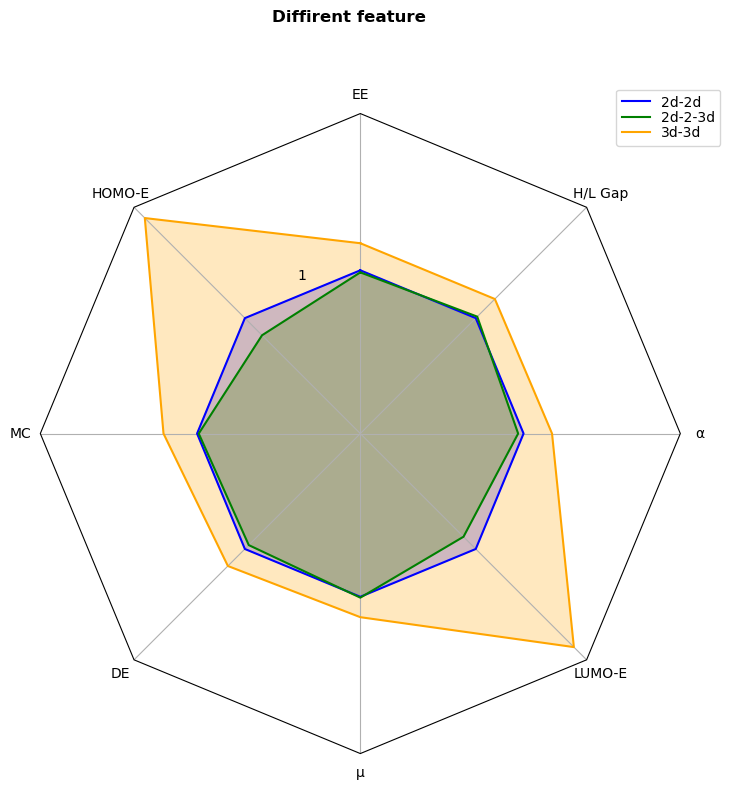

[-0.23, 2.15, -2.83]

In [143]:
title = 'Diffirent feature'
experiments = ['SCnet-GCN_se_no_laplace_2d_2d_1','SCnet-GCN_se_no_laplace_2d_2-3d_1','SCnet-GCN_se_no_laplace_3d_3d_1']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['2d-2d','2d-2-3d','3d-3d']
radar(data,label,index,title)
cal_area(data)

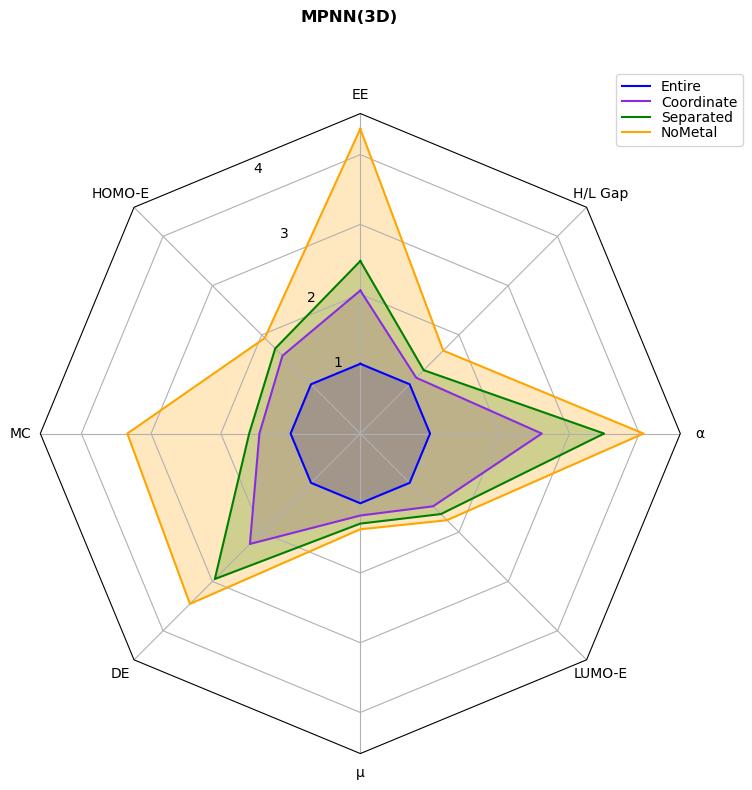

In [9]:
title = 'MPNN(3D)'
experiments = ['MPNN_en_no_xyz_2d_3d_1','MPNN_se_att16_xyz_2d_3d_1','MPNN_se_no_xyz_2d_3d_1','MPNN_se_no_xyz_2d_3d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

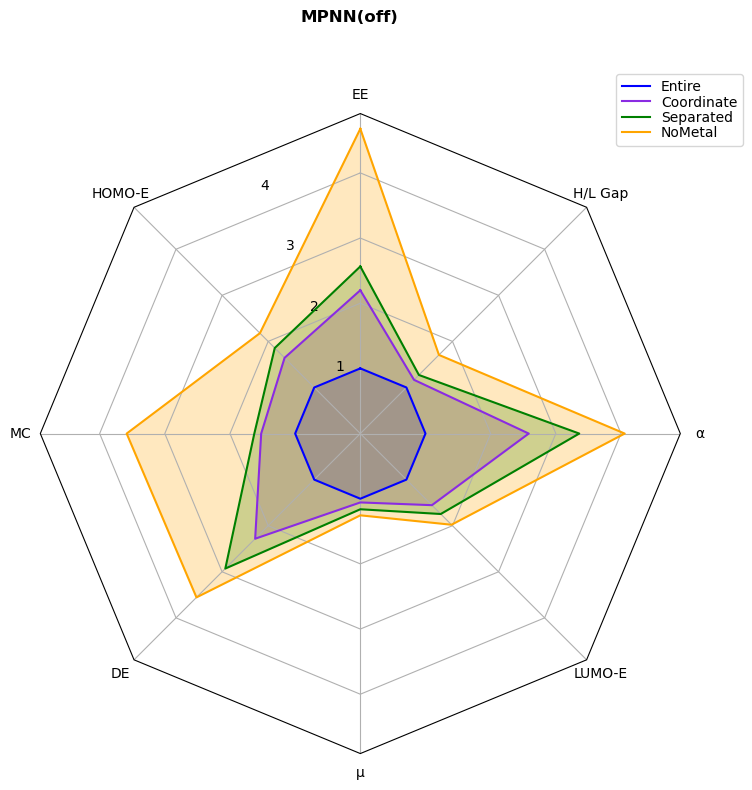

In [10]:
title = 'MPNN(off)'
experiments = ['MPNN_en_no_xyz_2d_off_1','MPNN_se_att16_xyz_2d_off_1','MPNN_se_no_xyz_2d_off_1','MPNN_se_no_xyz_2d_off_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

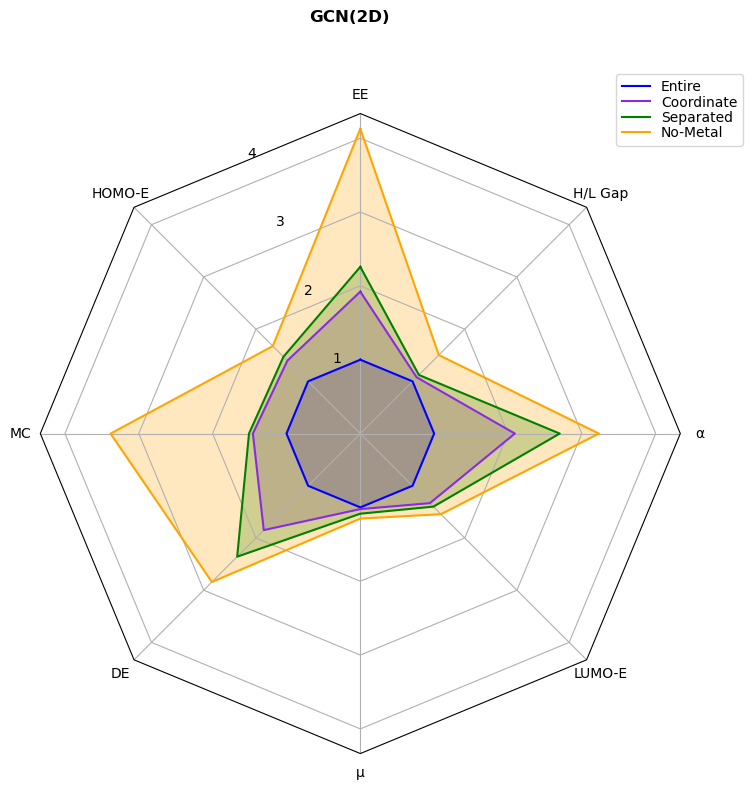

In [11]:
title = 'GCN(2D)'
experiments = ['SCnet-GCNs_en_no_laplace_2d_2d_1','SCnet-GCNs_se_att16_laplace_2d_2d_1','SCnet-GCNs_se_no_laplace_2d_2d_1','SCnet-GCNs_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','No-Metal']
radar(data,label,index,title)
areas.append(cal_area(data))

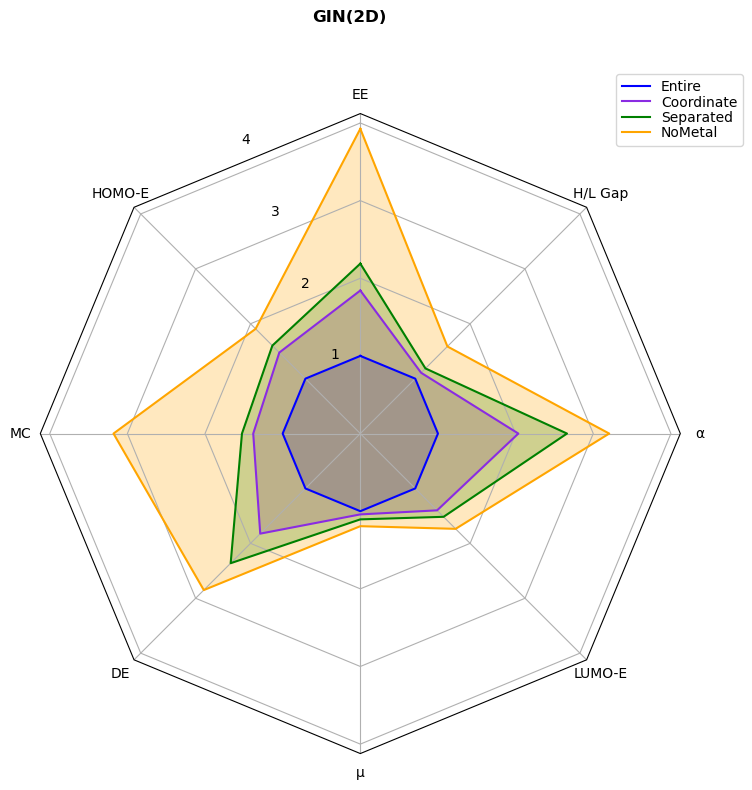

In [12]:
title = 'GIN(2D)'
experiments = ['SCnet-GIN_en_no_laplace_2d_2d_1','SCnet-GIN_se_att16_laplace_2d_2d_1','SCnet-GIN_se_no_laplace_2d_2d_1','SCnet-GIN_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

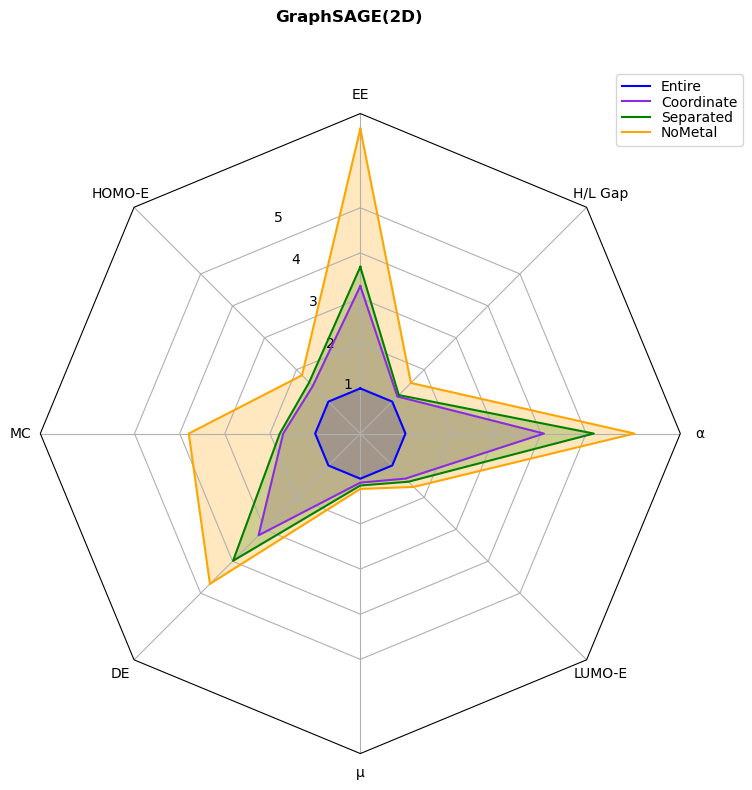

In [13]:
title = 'GraphSAGE(2D)'
experiments = ['SCnet-GraphSAGE_en_no_laplace_2d_2d_1','SCnet-GraphSAGE_se_att16_laplace_2d_2d_1','SCnet-GraphSAGE_se_no_laplace_2d_2d_1','SCnet-GraphSAGE_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

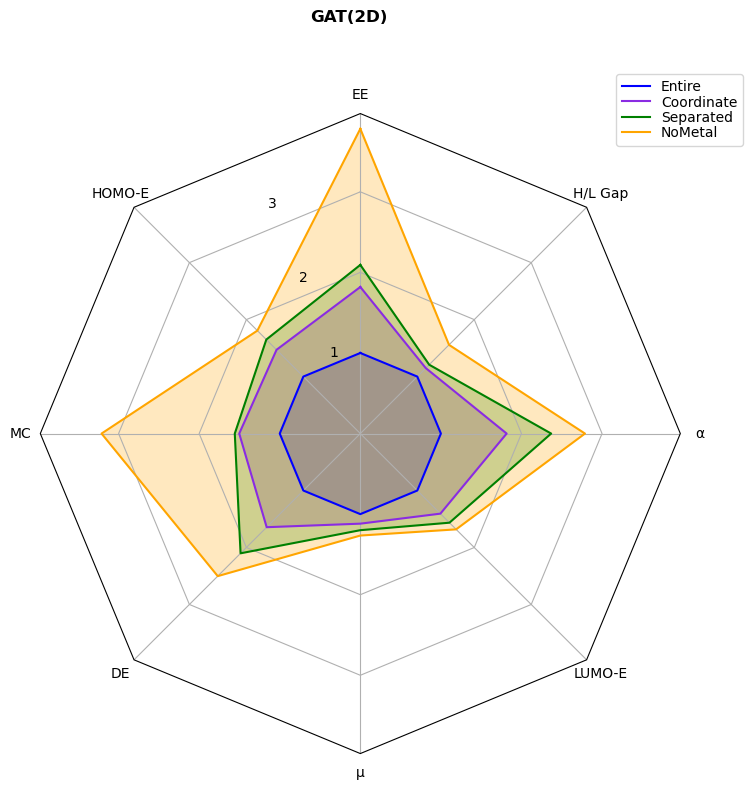

In [14]:
title = 'GAT(2D)'
experiments = ['SCnet-GAT_en_no_laplace_2d_2d_1','SCnet-GAT_se_att16_laplace_2d_2d_1','SCnet-GAT_se_no_laplace_2d_2d_1','SCnet-GAT_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

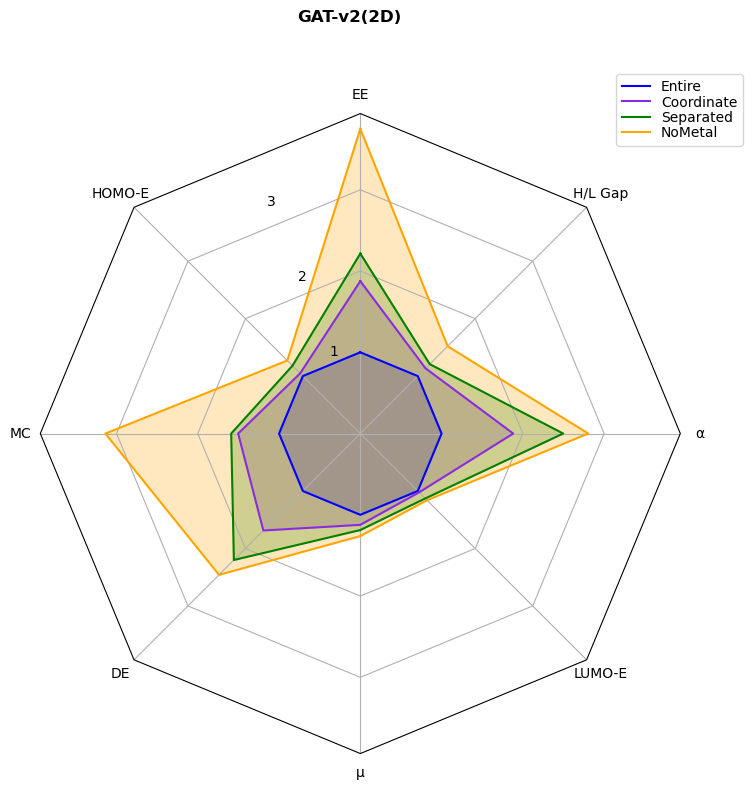

In [15]:
title = 'GAT-v2(2D)'
experiments = ['SCnet-GAT-v2_en_no_laplace_2d_2d_1','SCnet-GAT-v2_se_att16_laplace_2d_2d_1','SCnet-GAT-v2_se_no_laplace_2d_2d_1','SCnet-GAT-v2_se_no_laplace_2d_2d_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

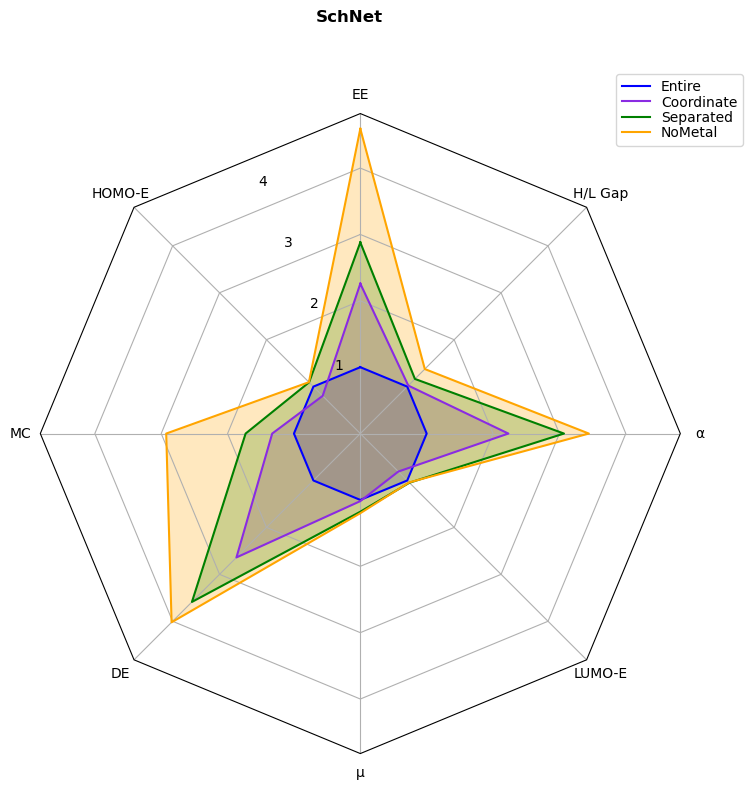

In [16]:
title = 'SchNet'
experiments = ['SchNet_en_no_xyz_3d_off_1','SchNet_se_att16_xyz_3d_2d_1','SchNet_se_no_xyz_3d_2d_1','SchNet_se_no_xyz_3d_off_0']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['Entire','Coordinate','Separated','NoMetal']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

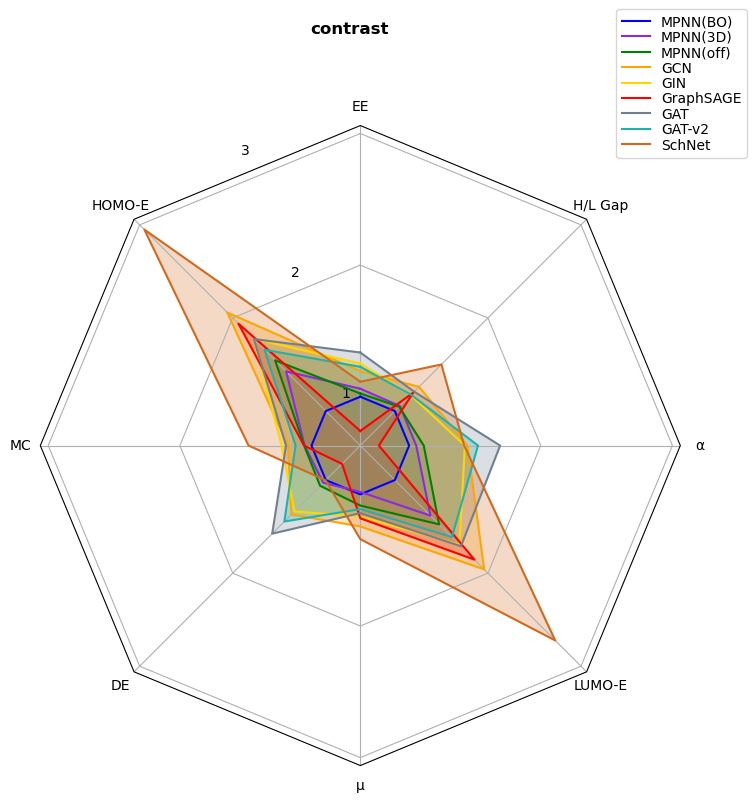

In [20]:
title = 'contrast'
experiments = ['SCnet-GCN_en_no_laplace_2d_2d_1','MPNN_en_no_xyz_2d_3d_1','MPNN_en_no_xyz_2d_off_1','SCnet-GCNs_en_no_laplace_2d_2d_1','SCnet-GIN_en_no_laplace_2d_2d_1','SCnet-GraphSAGE_en_no_laplace_2d_2d_1','SCnet-GAT_en_no_laplace_2d_2d_1','SCnet-GAT-v2_en_no_laplace_2d_2d_1','SchNet_en_no_xyz_3d_off_1']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
index = ['MPNN(BO)','MPNN(3D)','MPNN(off)','GCN','GIN','GraphSAGE','GAT','GAT-v2','SchNet']
radar(data,label,index,title)
areas.append(cal_area(data,False,index[:-1],title))

In [21]:
areas

[[1.0, 2.2, 3.23, 4.72],
 [1.0, 2.78, 3.88, 6.87],
 [1.0, 2.9, 3.92, 7.58],
 [1.0, 2.22, 2.81, 5.41],
 [1.0, 2.22, 2.95, 5.62],
 [1.0, 4.01, 5.09, 9.43],
 [1.0, 2.19, 2.85, 5.11],
 [1.0, 1.91, 2.56, 4.28],
 [1.0, 2.04, 3.35, 5.09],
 [1.0, 1.27, 1.37, 2.1, 1.89, 1.34, 2.08, 1.83, 2.72],
 [1.0, 1.27, 1.37, 2.1, 1.89, 1.34, 2.08, 1.83, 2.72]]

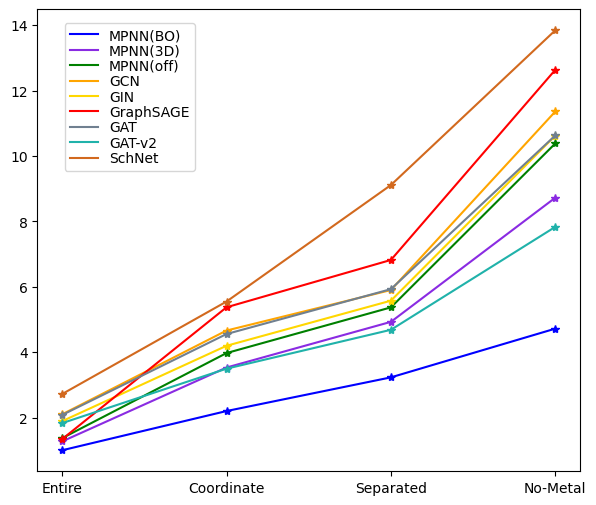

In [26]:
data = np.array(areas[:9])
for i in range(9):
    data[i,:] *= areas[9][i]
plt.figure(figsize=(7,6))
title = 'contrast'
index = ['Entire','Coordinate','Separated','No-Metal']
colors = ['blue','blueviolet','green', 'orange','gold','red','slategray','lightseagreen','chocolate']
labels = ['MPNN(BO)','MPNN(3D)','MPNN(off)','GCN','GIN','GraphSAGE','GAT','GAT-v2','SchNet']
for i in range(9):
    plt.plot(index,data[i,:],'-',color=colors[i],label=labels[i])
    plt.plot(index,data[i,:],'*',color=colors[i])
legend = plt.legend(loc=(0.05, .65),labelspacing=0.1, fontsize='medium')
plt.savefig('./results/'+title+'.tif',dpi=600)
plt.show()

#### 制表

In [187]:
title = 'GCN(2D)'
experiments = ['SCnet-GCN_en_no_laplace_2d_2d_1','SCnet-GCN_se_att_laplace_2d_2d_1','SCnet-GCN_se_no_laplace_2d_2d_1','SCnet-GCN_se_no_laplace_2d_2d_0']
index = ['Entire','Simple','Coor-separated','NoMetal']
table(experiments,title,index,'w')

In [115]:
title = 'GCN(3D)'
experiments = ['SCnet-GCN_en_no_laplace_3d_3d_1','SCnet-GCN_se_att_laplace_3d_3d_1','SCnet-GCN_se_no_laplace_3d_3d_1']
table(experiments,title)

In [16]:
title = 'GIN(2D)'
experiments = ['SCnet-GIN_en_no_laplace_2d_2d_1','SCnet-GIN_se_att16_laplace_2d_2d_1','SCnet-GIN_se_no_laplace_2d_2d_1','SCnet-GIN_se_no_laplace_2d_2d_0']
index = ['Entire','Simple','Coor-separated','NoMetal']
table(experiments,title,index)

In [7]:
title = 'MPNN(off)'
experiments = ['MPNN_en_no_xyz_2d_off_1','MPNN_se_att16_xyz_2d_off_1','MPNN_se_no_xyz_2d_off_1','MPNN_se_no_xyz_2d_off_0']
index = ['Entire','Simple','Coor-separated','NoMetal']
table(experiments,title,index)

In [29]:
title = 'MPNN(3D)'
experiments = ['MPNN_en_no_DG_2d_3d_1','MPNN_se_att16_DG_2d_3d_1','MPNN_se_no_DG_2d_3d_1','MPNN_se_no_DG_2d_3d_0']
index = ['Entire','Coordinate','Separated','NoMetal']
table(experiments,title,index)

In [17]:
title = 'GraphSAGE(2D)'
experiments = ['SCnet-GraphSAGE_en_no_laplace_2d_2d_1','SCnet-GraphSAGE_se_att16_laplace_2d_2d_1','SCnet-GraphSAGE_se_no_laplace_2d_2d_1','SCnet-GraphSAGE_se_no_laplace_2d_2d_0']
index = ['Entire','Coordinate','Separated','NoMetal']
table(experiments,title,index)

In [ ]:
title = 'GAT(2D)'
experiments = ['SCnet-GAT_en_no_laplace_2d_2d_1','SCnet-GAT_se_att16_laplace_2d_2d_1','SCnet-GAT_se_no_laplace_2d_2d_1','SCnet-GAT_se_no_laplace_2d_2d_0']
index = ['Entire','Coordinate','Separated','NoMetal']
table(experiments,title,index)

In [21]:
title = 'GAT-v2(2D)'
experiments = ['SCnet-GAT-v2_en_no_laplace_2d_2d_1','SCnet-GAT-v2_se_att16_laplace_2d_2d_1','SCnet-GAT-v2_se_no_laplace_2d_2d_1','SCnet-GAT-v2_se_no_laplace_2d_2d_0']
index = ['Entire','Coordinate','Separated','NoMetal']
table(experiments,title,index)

In [12]:
title = 'SchNet'
experiments = ['SchNet_en_no_xyz_3d_off_1','SchNet_se_att16_xyz_3d_2d_1','SchNet_se_no_xyz_3d_2d_1','SchNet_se_no_xyz_3d_off_0']
index = ['Entire','Coordinate','Separated','NoMetal']
table(experiments,title,index)

In [ ]:
title = 'SchNet'
experiments = ['SchNet_en_no_xyz_3d_off_1','SchNet_se_att16_xyz_3d_2d_1','SchNet_se_no_xyz_3d_2d_1','SchNet_se_no_xyz_3d_off_0']
index = ['Entire','Coordinate','Separated','NoMetal']
table(experiments,title,index)

#### 参数分析

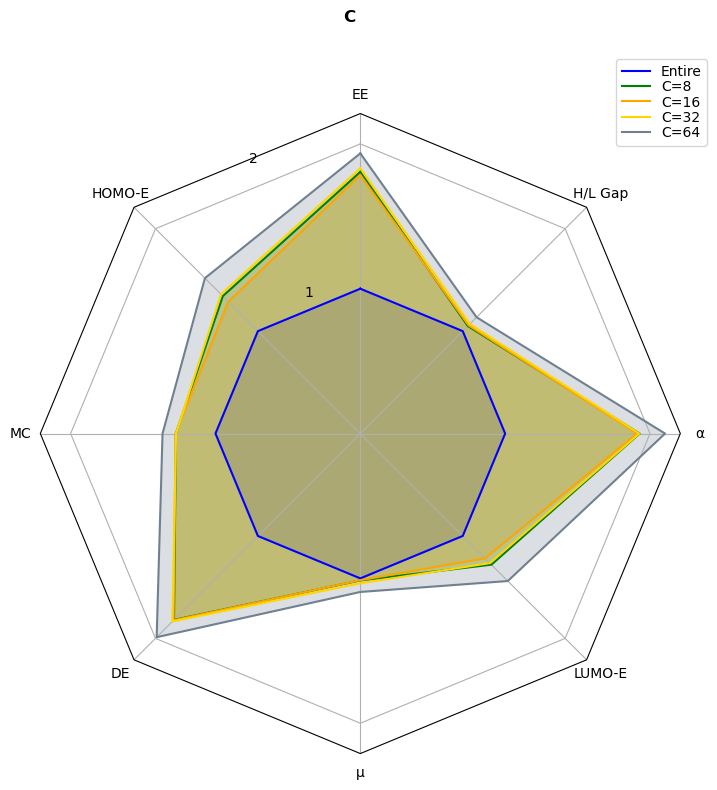

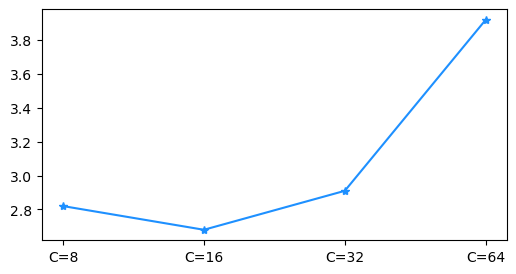

[2.82, 2.68, 2.91, 3.92, -2.83]

In [12]:
title = 'C'
index = ['Entire','C=8','C=16','C=32','C=64']
experiments = ['SCnet-GCN_en_no_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att8_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att16_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att32_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att64_laplace_2d_2-3d_1']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
radar(data,label,index,title)
cal_area(data,plot=True,lable=index[1:],title='C-line')

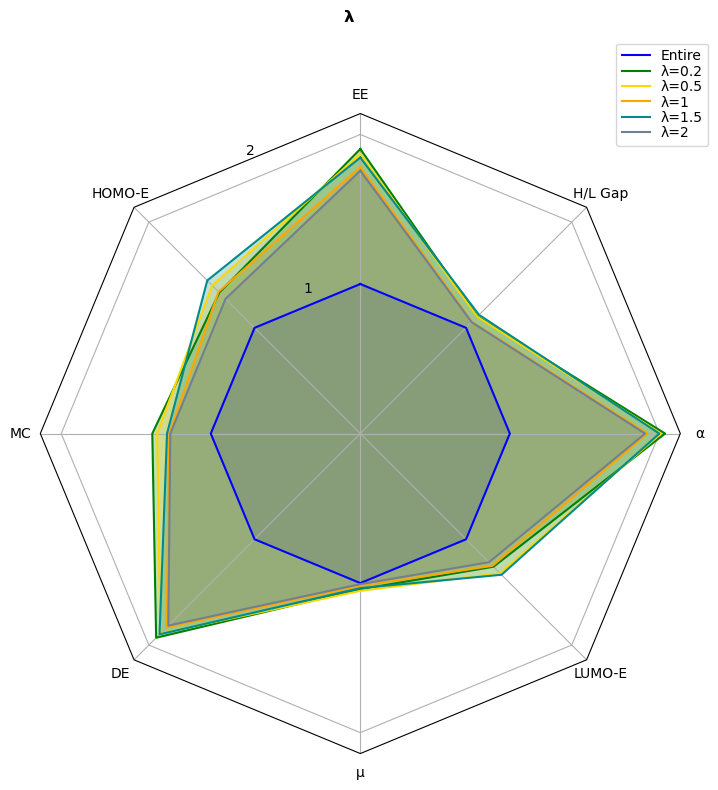

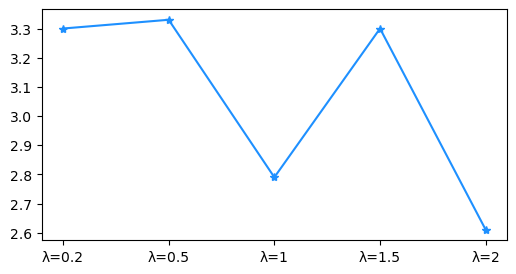

[3.3, 3.33, 2.79, 3.3, 2.61, -2.83]

In [171]:
title = '\u03BB'
index = ['Entire','\u03BB=0.2','\u03BB=0.5','\u03BB=1','\u03BB=1.5','\u03BB=2']
experiments = ['SCnet-GCN_en_no_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att_laplace_2d_2-3d_0.2',
               'SCnet-GCN_se_att_laplace_2d_2-3d_0.5',
               'SCnet-GCN_se_att_laplace_2d_2-3d_1',
               'SCnet-GCN_se_att_laplace_2d_2-3d_1.5',
               'SCnet-GCN_se_att_laplace_2d_2-3d_2']
means,std = read_data(experiments)
data = np.round(means/means[0,:],4)
data = data[:,rank].tolist()
radar(data,label,index,title)
cal_area(data,plot=True,lable=index[1:],title='C-line')

#### 可解释性

In [2]:
def importance(idx,model,start,dataset):
    _,weight,s = model(dataset[idx])
    imp = s.squeeze() @ weight.squeeze().T
    imp_sort = torch.argsort(imp)

    acc = False

    temp = []

    for node in nodes[idx]:
        temp += node

    m = 0
    n = len(temp)
    for s in start[idx]:
        if s in temp:
            m += 1
    for i in imp_sort[-3:]:
        if temp[i] in start[idx]:
            acc = True
            break
    prop = 1 - (math.factorial(n-m)/math.factorial(n-m-3))*((math.factorial(n-3)/math.factorial(n)))

    return imp,acc,prop

In [3]:
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
dataset = tmQM_dataset(config['path'],config['separated'],config['data']['pe'])
dataloader = tmQM_wrapper(config['path'],config['batch_size'],separated=config['separated'],predata=dataset,**config['data'])
complexes = dataset.complexes
adjs = dataset.adjs
nodes = dataset.nodes
with open('./dataset/Data/start.pkl','rb') as f:
    start = pickle.load(f)
path_list = ['./experiment/GraphSAGE_se_att16_xyz_2d_2d_1_interprate/Jan31_21-53-15_GraphSAGE_se_att16_xyz_2d_2d_1_interprate/checkpoints/model.pth',
             './experiment/GraphSAGE_se_att16_xyz_2d_2d_1_interprate/Jan31_22-42-37_GraphSAGE_se_att16_xyz_2d_2d_1_interprate/checkpoints/model.pth',
             './experiment/GraphSAGE_se_att16_xyz_2d_2d_1_interprate/Jan31_23-43-14_GraphSAGE_se_att16_xyz_2d_2d_1_interprate/checkpoints/model.pth',
             './experiment/GraphSAGE_se_att16_xyz_2d_2d_1_interprate/Feb01_00-40-56_GraphSAGE_se_att16_xyz_2d_2d_1_interprate/checkpoints/model.pth']
# f = open('./experiment/MPNN_se_att16_laplace_2d_2d_1_interprate/testset.pkl','rb')
# test_idx = pickle.load(f)
models = ['MPNN','GIN','GAT','GAT-v2','GraphSAGE','SchNet']
Acc = []
Prop = []
config['model'] = models[4]
ACCs = []
for path in path_list:
    model_path = path
# if m == 'MPNN':
#     config['GNN']['edge_type'] = 'off'
    model = SCnet(
                GNN_config=config['GNN'],
                Coor_config=config['Coor_config'],
                out_dimention=config['out_dimention'],
                separated=config['separated'],
                attention=config['attention'],
                gnn=config['model']
            )
    net = torch.load(model_path)
    model_dict = model.state_dict()
    model_dict.update(net)
    model.load_state_dict(model_dict)
    imp_list = []
    acc_list = []
    prop_list = []
    error = []
    right = []
    for i in tqdm(range(len(dataset))):
        try:
            imp,acc,prop = importance(i,model,start,dataset)
            imp_list.append(imp)
            acc_list.append(acc)
            prop_list.append(prop)
            right.append(i)
        except:
            error.append(i)
    ACCs.append(sum(acc_list)/len(acc_list))
    print(config['model'])
    print(f'ACC:{sum(acc_list)/len(acc_list)}')
    print(f'prop:{np.mean(np.array(prop_list))}')

ERROR SAMPLE:GEJBUS
ERROR SAMPLE:OKAPEX


  0%|          | 0/86665 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_34596\1908790788.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3575.)
  imp = s.squeeze() @ weight.squeeze().T
100%|██████████| 86665/86665 [15:32<00:00, 92.97it/s]  


GraphSAGE
ACC:0.39637867051879155
prop:0.2915998211014603


100%|██████████| 86665/86665 [16:32<00:00, 87.28it/s]  


GraphSAGE
ACC:0.2947622724216084
prop:0.2915998211014603


In [76]:
with open('./dataset/Data/start.pkl','rb') as f:
    start = pickle.load(f)

In [ ]:
0.6784 

In [117]:
imp,acc,prop = importance(7,model,start,dataset)
print(acc)
print(prop)

True
0.292013567684243


In [121]:
imp_sort = torch.argsort(imp)
imp_sort

tensor([37, 40, 18,  8, 27, 35, 44, 43, 41, 42,  4, 14, 26, 19, 33,  9, 36, 23,
        30, 13, 20, 31, 10,  5, 15, 25, 45, 32, 21, 12, 29, 17, 11, 39, 22, 38,
         7, 28, 46,  0,  6,  2, 24,  1, 16,  3, 34])

In [123]:
scale_imp = (imp-min(imp))/(max(imp)-min(imp))

In [124]:
scale_imp

tensor([0.7488, 0.9279, 0.8853, 0.9664, 0.1919, 0.4491, 0.8411, 0.6766, 0.1184,
        0.2149, 0.3817, 0.6250, 0.6038, 0.3556, 0.1974, 0.4588, 0.9395, 0.6238,
        0.1165, 0.2001, 0.3644, 0.5811, 0.6437, 0.3345, 0.9036, 0.4617, 0.1982,
        0.1189, 0.6996, 0.6103, 0.3526, 0.3791, 0.5699, 0.2066, 1.0000, 0.1253,
        0.3280, 0.0000, 0.6720, 0.6279, 0.0023, 0.1442, 0.1682, 0.1380, 0.1287,
        0.4755, 0.7185], grad_fn=<DivBackward0>)

In [130]:
atoms = [0,1,2,3,6,7,8,10,12,16,17,18,20,22,24,27,28,30,31,34,35,36,37,40]

Color for value 0.002317621372640133: (0.9686274509803922, 0.984313725490196, 1.0, 1.0)


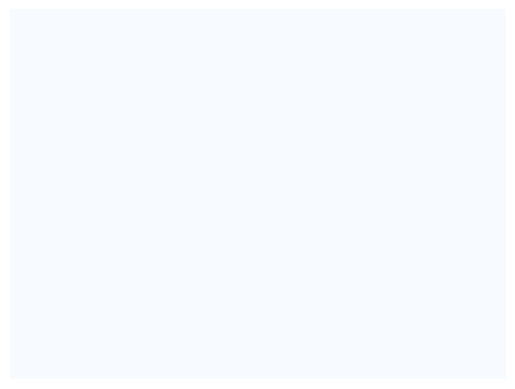

In [164]:
from matplotlib.colors import Normalize
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# 获取特定值对应的颜色
specific_value = scale_imp[40].item()
color_for_specific_value = plt.cm.Blues(norm(specific_value))

# 打印颜色
print(f"Color for value {specific_value}: {color_for_specific_value}")

fig, ax = plt.subplots()
ax.imshow([[color_for_specific_value]], aspect='auto', extent=(0, 1, 0, 1))
ax.set_axis_off()

ATECUZ


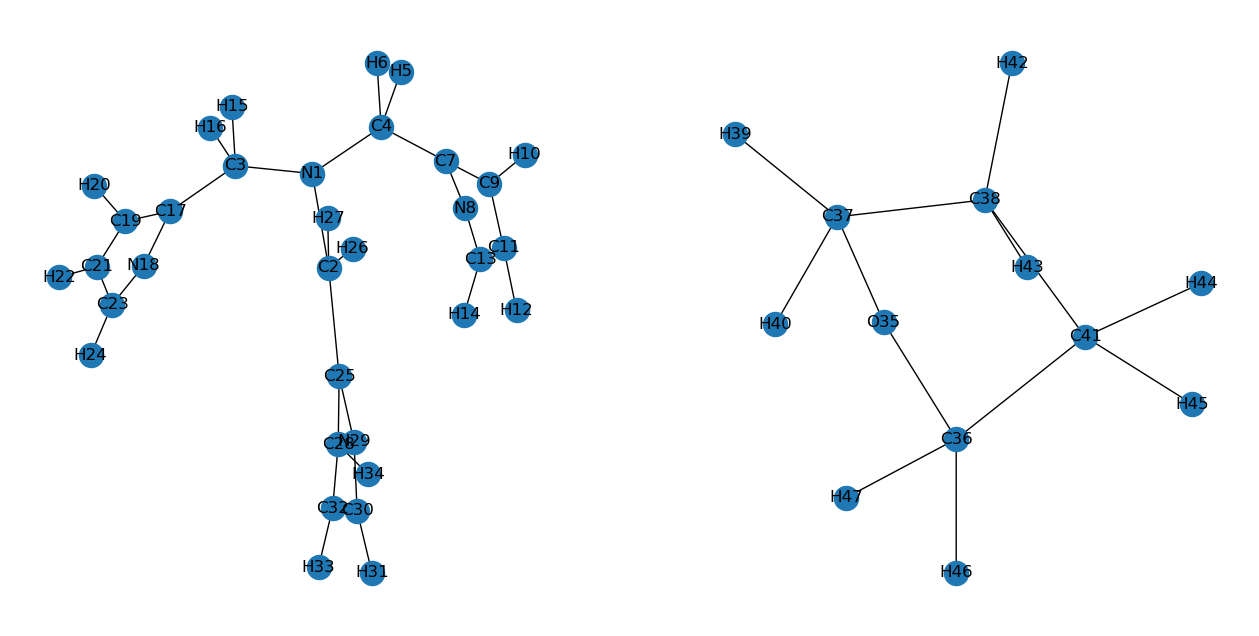

In [119]:
draw_ligands(7,complexes,adjs,nodes)

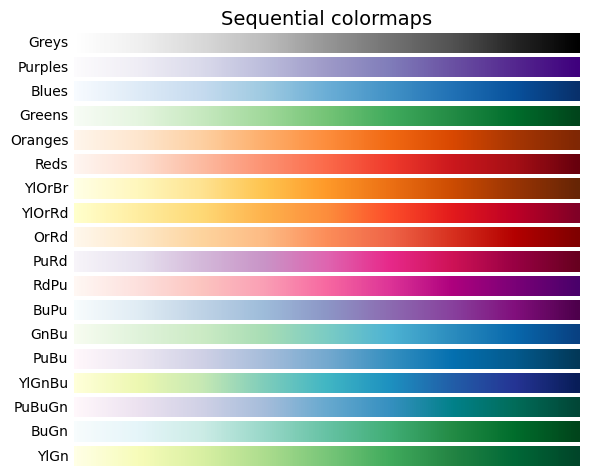

In [2]:
import matplotlib.pyplot as plt
import numpy as np

cmaps = [('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),]

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(f"{cmap_category} colormaps", fontsize=14)

    for ax, cmap_name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, cmap_name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()


for cmap_category, cmap_list in cmaps:
    plot_color_gradients(cmap_category, cmap_list)

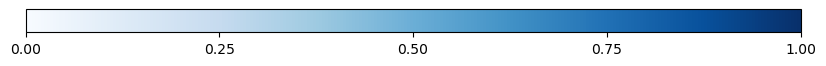

In [9]:
import matplotlib.cm as cm
import copy
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1, 1, figsize=(10, 0.3))
cmap1 = copy.copy(cm.Blues)
norm1 = mcolors.Normalize(vmin=0, vmax=1)
im1 = cm.ScalarMappable(norm=norm1, cmap=cmap1)
cbar1 = fig.colorbar(
    im1, cax=axes, orientation='horizontal',
    ticks=np.linspace(0, 1, 5),
    label=None
)
plt.savefig('./results/''colorbar.tif',dpi=600)

#### 金属外推

In [2]:
model_path = './experiment/MPNN_se_no_xyz_2d_2d_1_metal/Feb01_23-41-54_MPNN_se_no_xyz_2d_2d_1_metal/checkpoints/model.pth'
mean = [-3.5211e+03, -1.3349e-01,  5.5814e+00,  2.1986e-01,  1.0040e-01,
        -2.0299e-01, -1.0258e-01,  3.7501e+02]
std = [1.6127e+03, 6.8856e-02, 3.6377e+00, 6.0468e-01, 3.5232e-02, 6.8615e-02,
        6.9374e-02, 1.5422e+02]
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
print(config['separated'])
print(config['attention'])
model = SCnet(
            GNN_config=config['GNN'],
            Coor_config=config['Coor_config'],
            out_dimention=config['out_dimention'],
            separated=config['separated'],
            attention=config['attention'],
            gnn=config['model']
        )
net = torch.load(model_path)
model_dict = model.state_dict()
model_dict.update(net)
model.load_state_dict(model_dict)
exp_metal = [21,23,25,27,29]
result = []
with torch.no_grad():
    model.eval()
for metal in tqdm(exp_metal):
    pred = []
    label = []
    dataset = tmQM_dataset(config['path'],config['separated'],config['data']['pe'],metal_list=[metal])
    for i in range(len(dataset)):
        try:
            pred.append(model(dataset[i]))
            label.append(dataset[i].y)
        except:
            pass
    result.append([pred,label])

True
False


100%|██████████| 5/5 [11:54<00:00, 142.93s/it]


In [ ]:
model_path = './experiment/MPNN_se_att16_xyz_2d_2d_1_metal/Feb01_23-53-07_MPNN_se_att16_xyz_2d_2d_1_metal/checkpoints/model.pth'
mean = [-3.5343e+03, -1.3452e-01,  5.5947e+00,  2.2432e-01,  1.0082e-01,
        -2.0349e-01, -1.0267e-01,  3.7738e+02]
std = [1.6252e+03, 7.0330e-02, 3.6571e+00, 6.0109e-01, 3.5219e-02, 6.8871e-02,
        6.9903e-02, 1.5739e+02]
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
print(config['separated'])
print(config['attention'])
model = SCnet(
            GNN_config=config['GNN'],
            Coor_config=config['Coor_config'],
            out_dimention=config['out_dimention'],
            separated=config['separated'],
            attention=config['attention'],
            gnn=config['model']
        )
net = torch.load(model_path)
model_dict = model.state_dict()
model_dict.update(net)
model.load_state_dict(model_dict)
exp_metal = [21,23,25,27,29]
result = []
with torch.no_grad():
    model.eval()
for metal in tqdm(exp_metal):
    pred = []
    label = []
    dataset = tmQM_dataset(config['path'],config['separated'],config['data']['pe'],metal_list=[metal])
    for i in range(len(dataset)):
        try:
            pred.append(model(dataset[i]))
            label.append(dataset[i].y)
        except:
            pass
    result.append([pred,label])

In [3]:
def regression(p,t,title=None):
    ref = [min(t),max(t)]
    plt.figure(figsize=(6,6))
    plt.plot(ref,ref,'--',color='red')
    plt.scatter(t,p,color=(0.03125, 0.24609, 0.5078125, 0.05),edgecolors=(1,1,1,0))
    R2 = sm.r2_score(t,p)
    rmse = np.sqrt(sm.mean_squared_error(t,p))
    mae = sm.mean_absolute_error(t,p)
    plt.text(np.min(t)+0.08*(np.max(t)-np.min(t)),np.max(t)-0.08*(np.max(t)-np.min(t)),'$R^2$ = {}'.format(np.around(R2,4)),fontsize='large')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    if title != None:
        plt.savefig('./results/'+title+'.tif',dpi=600)
    plt.show()

In [8]:
ind = 4
r2s = []
preds = []
labels = []
for res in result:
    preds.append(torch.cat(res[0],dim=0))
    temp = []
    for lab in res[1]:
        temp.append(lab.unsqueeze(dim=0))
    labels.append(torch.cat(temp,dim=0))
# preds = torch.cat(preds[0:2],dim=0).detach().numpy()
# labels = torch.cat(labels[0:2],dim=0).detach().numpy()
preds = preds[ind].detach().numpy()
labels = labels[ind].detach().numpy()
preds = preds*std + mean
for i in range(preds.shape[1]):
    R2 = sm.r2_score(preds[:,i],labels[:,i])
    r2s.append(R2)
r2s

[0.73444739281598,
 0.4305797494834124,
 -0.4613751188906894,
 -3.898658894368853,
 -1.6313921707086276,
 -0.9006279191147526,
 0.15363994145339843,
 0.5142023729758433]

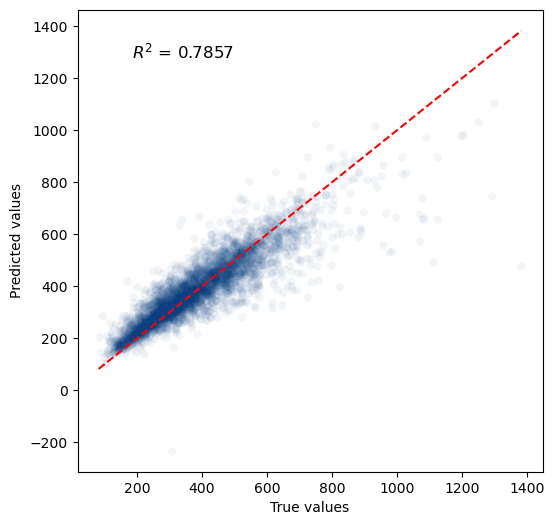

In [103]:
ind = 7
regression(preds[:,ind],labels[:,ind])